In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import linear_model
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso as lasso
import plotly.express as px
from sklearn.decomposition import PCA

### Import data

In [3]:
df = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-conversations.jsonl.gz",
    lines=True,
    compression="gzip")

topic_and_hardness = pd.read_json(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-gpt3-scores.jsonl.gz",
    lines=True,
    compression="gzip")

prompt_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-prompts-embeddings.npy"))

response_a_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_a_response-embeddings.npy"))

response_b_embeddings = pd.DataFrame(np.load(
    "data/nlp-chatbot-analysis_data/training-set/chatbot-arena-model_b_response-embeddings.npy"))

# Cleaning invalid non-NaN values

In [5]:
def take_out_list(one_series_element):
    '''
    Input: one_series_element is a single string element or a nested list.
    Output: one_series_element or the nested item in the one_series_element if one_series_element is a list. 
    '''
    if isinstance(one_series_element, list):
        return one_series_element[0][0]
    else:
        return one_series_element

In [6]:
score_value_1_cleaned = topic_and_hardness["score_value_1"].apply(take_out_list)
score_value_2_cleaned = topic_and_hardness["score_value_2"].apply(take_out_list)
score_value_3_cleaned = topic_and_hardness["score_value_3"].apply(take_out_list)
topic_and_hardness["score_value_1"] = score_value_1_cleaned
topic_and_hardness["score_value_2"] = score_value_2_cleaned
topic_and_hardness["score_value_3"] = score_value_3_cleaned

topic_value_1_cleaned = topic_and_hardness["topic_modeling_1"].apply(take_out_list)
topic_value_2_cleaned = topic_and_hardness["topic_modeling_2"].apply(take_out_list)
topic_value_3_cleaned = topic_and_hardness["topic_modeling_3"].apply(take_out_list)
topic_and_hardness["topic_modeling_1"] = topic_value_1_cleaned
topic_and_hardness["topic_modeling_2"] = topic_value_2_cleaned
topic_and_hardness["topic_modeling_3"] = topic_value_3_cleaned

# Get top 500 most frequently occuring topics as features without losing rows nor creating NaN values.

In [8]:
# Select top 500 most frequently occuring topics 
encode_topics = topic_and_hardness["topic_modeling_2"].value_counts().head(500).index

# Create a dictionary to map topics to an integer + an integer for topics not frequently occuring. 
indexes = [i for i in range(len(encode_topics))]
encoded_500_topics = dict(zip(encode_topics, indexes))
encoded_500_topics['NOT_FREQUENT'] = 500

# Create column that is almost identical to 'topic_modeling_1' except, rename all topics that are not in the top 500 as "NOT_FREQUENT". 
topic_and_hardness["topic_modeling_2_preprocessed"] = topic_and_hardness['topic_modeling_2'].where(topic_and_hardness['topic_modeling_2'].isin(encode_topics), 'NOT_FREQUENT')
topic_and_hardness['topic_mapped'] = topic_and_hardness['topic_modeling_2_preprocessed'].map(encoded_500_topics)

one_hot_encoded_500_topics = pd.get_dummies(topic_and_hardness["topic_mapped"]).astype(int)
topic_and_hardness_top500_topics = pd.merge(topic_and_hardness,one_hot_encoded_500_topics, left_index=True, right_index=True)

# DROP ROWS WITH MISSING VALUES

In [10]:
nan_rows = topic_and_hardness[topic_and_hardness.isna().any(axis=1)]
nan_indices = nan_rows.index.tolist()

one_hot_encoded_500_topics.drop(nan_indices, inplace=True)
topic_and_hardness.drop(nan_indices, inplace=True)

# FEATURE ENGINEER HARDNESS SCORE.
Averageing the individual 3 hardness scores and rounding them to the nearest integer helped simplify model training and prevent over-fitting.

In [12]:
def rounding(series_element):
    '''
    Input: an element in a series of floats.
    Output: integer that was rounded to the nearest integer from the input. 
    '''
    decimal_part = series_element - int(series_element)
    if decimal_part >= 0.5:
        return math.ceil(series_element)
    else:
        return math.floor(series_element)

In [13]:
# Feature engineer: average_hardness_score
topic_and_hardness['average_hardness_score'] = topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].mean(axis=1)

# Feature engineer: discrete values of average_hardness_score
topic_and_hardness['rounded_average_hardness_score'] = topic_and_hardness['average_hardness_score'].apply(rounding)

# CREATE DESIGN MATRIX.
We incorporated latent features from PCA on one-hot-encoded topics into the design matrix. 
We incorporated prompt embeddings because it was the most influential feature that determined the hardness score. 

In [15]:
X = one_hot_encoded_500_topics.copy()

In [16]:
X.columns = X.columns.astype(str)

# SPLIT DATA 80/20 FOR TRAINING AND VALIDATION SET. 

In [18]:
Y = topic_and_hardness["rounded_average_hardness_score"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=11)

# Perform PCA on X with the number of n_components that capture 95% variability of test sets.

In [20]:
pca = PCA(n_components=378)  
X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)

Explained_variability = pd.DataFrame(pca.explained_variance_ratio_ , columns=["95% Explained Variability"])
Explained_variability["Component"] = [ i for i in range(378)]
Explained_variability.set_index("Component")

,95% Explained Variability
Component,
0,0.367087
1,0.032264
2,0.028085
3,0.021310
4,0.016005
...,...
373,0.000439
374,0.000439
375,0.000439


# Visualize the cumulative explained variance for each component. 

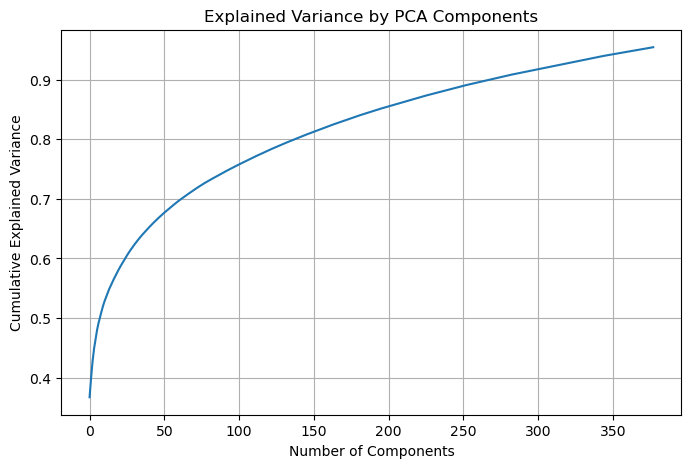

In [22]:
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
# plt.savefig('figure10.png', format='png')
plt.show()

In [23]:
# instatiate linear model
TASKB_lm = LinearRegression(fit_intercept = True)

# train model
TASKB_lm.fit(X_train_pca , y_train)

# make predictions
training_predictions = TASKB_lm.predict(X_train_pca)
testing_predictions = TASKB_lm.predict(X_test_pca)

# EVALUATE MODEL.

We chose to evaluate the model with mean squared error (mse), as that is considered the loss function used to measure the differences in actual vs. predicted values for linear regression. We also used r^2 as an evaluation metric to understand how well our model captures the variability in our data. Hyperparameters that were adjusted were 

In [25]:
def mse(actual_y, predicted_y):
    """
    Args:
        predicted_y: An array of the predictions from the model.
        actual_y: An array of the ground truth labels.
        
    Returns:
        The mean square error between the predictions and ground truth labels.
    """
    diff_sq = (actual_y - predicted_y)**2
    summation = np.sum(diff_sq)
    avg = summation/(len(diff_sq))
    return avg

In [26]:
# Calculating mse
print(f'training mse: {mse(y_train, training_predictions)}')
print(f'validation mse: {mse(y_test, testing_predictions)}')
print(f'R^2: {r2_score(y_train, training_predictions)}')

training mse: 2.430166789216752
validation mse: 2.4894276324800635
R^2: 0.19593678670605053


# Visualize performance
Initially, we used a scatter plot to visualize performance since a linear regression model should be used to predict continuous data. However, we faced over-plotting issues and decided to use a box-plot to visualize performance. The box-plot works in our favor to also visualize the distribution of predicted scores for every rounded hardness score.

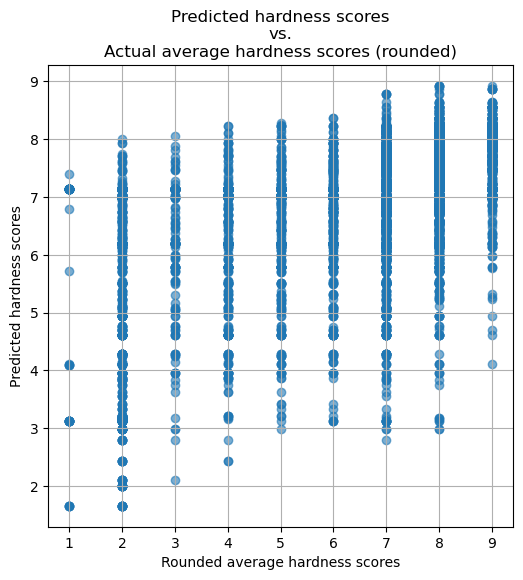

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(y_train, training_predictions, alpha=0.6)
plt.title('Predicted hardness scores\nvs.\nActual average hardness scores (rounded)')
plt.xlabel('Rounded average hardness scores')
plt.ylabel("Predicted hardness scores")
plt.grid(True)
plt.show()

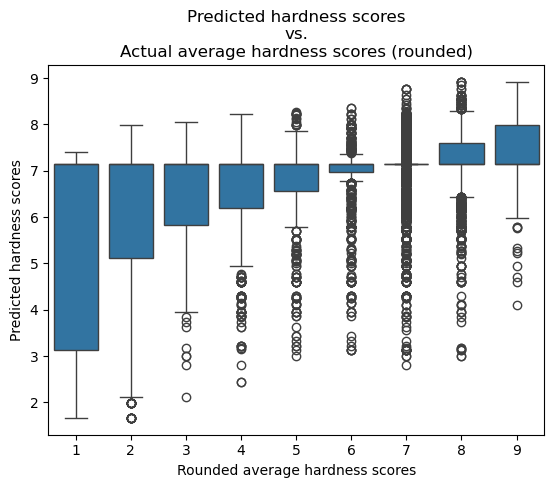

In [29]:
sns.boxplot(x=y_train, y=training_predictions)
plt.title('Predicted hardness scores\nvs.\nActual average hardness scores (rounded)')
plt.xlabel('Rounded average hardness scores')
plt.ylabel("Predicted hardness scores")
# plt.savefig('figure17.png', format='png')
plt.show()


# Additional evaluation metrics. 
After visualizing the box plot above, we thought of another way to measure performance by taking the rows, averaging each true hardness score found between 1 to 10 , and average their row's predicted hardness score, and taking the absolute differences between the averages. 

In [31]:
y_values = pd.DataFrame({"avg y": y_train, "avg y^": training_predictions})
print("Average y^hat prediction \nper true hardness score:")
y_values.groupby("avg y").agg("mean")

Average y^hat prediction 
per true hardness score:


,avg y^
avg y,
1,5.440643
2,6.108729
3,6.404872
4,6.598485
5,6.745062
6,6.857468
7,7.069262
8,7.311921
9,7.467223


In [32]:
differences = pd.DataFrame(y_values.groupby("avg y").agg("mean"))
differences.reset_index(inplace=True)
differences["abs(avg y - avg y^)"] = np.abs(differences["avg y"] - differences["avg y^"])
differences

,avg y,avg y^,abs(avg y - avg y^)
0,1,5.440643,4.440643
1,2,6.108729,4.108729
2,3,6.404872,3.404872
3,4,6.598485,2.598485
4,5,6.745062,1.745062
5,6,6.857468,0.857468
6,7,7.069262,0.069262
7,8,7.311921,0.688079
8,9,7.467223,1.532777


### To ensure a comprehensive evaluation, we also measured mean squared error 10 times with 10 different 80/20 splits in our training data using k-fold cross validation to ensure our evaluation metrics were not due to randomness of initial splits in our data. 

In [34]:
def compute_CV_error_with_pca(model, X_train, Y_train, n_components=0.95):
    '''
    Split the training data into 10 subsets.
    For each subset, 
        - Fit a PCA only on the training split.
        - Fit a model on the PCA-transformed training split.
        - Compute the MSE on the PCA-transformed validation split.
    Return the average validation MSE of these 10 folds.
    '''
    kf = KFold(n_splits=10)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx] 
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx] 
        
        # Fit PCA on training split
        pca = PCA(n_components=n_components)
        split_X_train_pca = pca.fit_transform(split_X_train)
        split_X_valid_pca = pca.transform(split_X_valid)

        # Fit the model
        model.fit(split_X_train_pca, split_Y_train)
        
        # Predict
        preds = model.predict(split_X_valid_pca)
        
        # Error
        error = mse(split_Y_valid, preds)
        validation_errors.append(error)
        
    return np.mean(validation_errors), validation_errors


In [35]:
mean_error, fold_errors = compute_CV_error_with_pca(LinearRegression(fit_intercept=True), X_train, y_train)

In [36]:
print(f'Average loss: {mean_error}')

Average loss: 2.5332128261120173


# Plotting our validation mse of each fold in our cross-validation of k=10. 

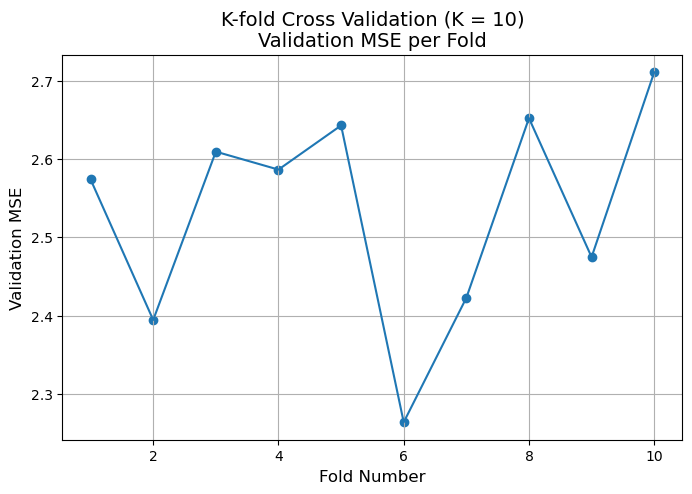

In [38]:
plt.figure(figsize=(8,5))
plt.scatter(range(1, 11), fold_errors)
plt.plot(range(1, 11), fold_errors)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Validation MSE', fontsize=12)
plt.title('K-fold Cross Validation (K = 10)\nValidation MSE per Fold', fontsize=14)
plt.grid(True)
plt.show()